In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import zscore
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

from lstm_ae import *

In [47]:
df = pd.read_csv('data/sepsis_df.csv')
df = df.iloc[:,1:] # omit the extra index column

state_cols = ['gender', 'age', 'elixhauser', 're_admission',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'cumulated_balance']

In [48]:
# z-score normalization (and de-normalization for later)

# these are either id or binary-valued columns
dont_touch_columns = ['icustayid', 'gender', 're_admission', 'mechvent', 'died_in_hosp', 'vaso_bin', 'iv_bin', 'terminal_state']

# this will store means and stds for each columns
col_gaussians = {}

def normalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        global col_gaussians
        col_gaussians[col.name] = (col.mean(), col.std())
        return zscore(col)


def denormalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        mean, std = col_gaussians[col.name]
        return (col * std) + mean


real_df = df.copy()
df = df.apply(normalize)

In [27]:
# state space representation using a recurrent (LSTM) autoencoder


class SepsisStateDataset(Dataset):
    """
    Torch dataset for sepsis state space data. Returns a tensor sequence of data 
    with size (seq_len, n_features). If the sequence is shorter than seq_len, it is
    padded with -1.
    """
    def __init__(self, df, state_cols, seq_len):
        self.sequences = []
        self.lengths = []
        
        for icustayid, group in df.groupby('icustayid'):
            seq = group[state_cols].values.astype(np.float32)
            length = len(seq)

            # pad with -1 if necessary
            if length < seq_len:
                pad = np.full((seq_len - length, len(state_cols)), -1)
                seq = np.concatenate([seq, pad], axis=0)

            seq = torch.tensor(seq, dtype=torch.float32)

            self.sequences.append(seq)
            self.lengths.append(length)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx]


def collate_fn(batch):
    sequences, lengths = zip(*batch)
    return torch.stack(sequences), torch.tensor(lengths)



SEQ_LEN = df['icustayid'].value_counts().max() # max # of datapoints for any patient in sepsis_df | 20
BATCH_SIZE = 64
LR = 0.001
N_EPOCHS = 500
N_FEATURES = len(state_cols) # 44
HIDDEN_DIM = 64
LATENT_DIM = 20

# split on ids to prevent splitting halfway through a trajectory
icustayids = df['icustayid'].unique()
cutoff1 = int(0.7 * len(icustayids))
cutoff2 = int(0.85 * len(icustayids))

train_ids = icustayids[:cutoff1]
train_df = df[df['icustayid'].isin(train_ids)]
train_dataset = SepsisStateDataset(train_df, state_cols, SEQ_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_ids = icustayids[cutoff1:cutoff2]
val_df = df[df['icustayid'].isin(val_ids)]
val_dataset = SepsisStateDataset(val_df, state_cols, SEQ_LEN)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_ids = icustayids[cutoff2:]
test_df = df[df['icustayid'].isin(test_ids)]
test_dataset = SepsisStateDataset(test_df, state_cols, SEQ_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAE(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def masked_mse_loss(output, target, pad_value=-1):
    mask = (target != pad_value)
    diff = (output - target)[mask]
    return torch.sum(diff**2) / torch.sum(mask)

In [27]:
# train and validate

train_losses = []
val_losses = []

for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    total_loss = 0
    for batch, lengths in train_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        optimizer.zero_grad()
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss)

    # validate every 50 epochs
    if epoch % 50 == 0:
        model.eval()
        total_loss = 0
        for batch, lengths in val_dataloader:
            batch = batch.to(device) # (batch_size, sequence_length, num_features)
            output = model(batch, lengths) # (batch_size, sequence_length, num_features)
            loss = masked_mse_loss(output, batch)
            total_loss += loss.item()

        val_losses.append(total_loss)
        
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [18:58<00:00,  2.28s/it]


In [28]:
# test

test_losses = []
model.eval()
for epoch in tqdm(range(N_EPOCHS)):
    total_loss = 0
    for batch, lengths in test_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        
    test_losses.append(total_loss)
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [01:48<00:00,  4.59it/s]


mean train loss: 53.73175884243846
mean val loss: 16.19418148994446
mean test loss: 12.007966956734657


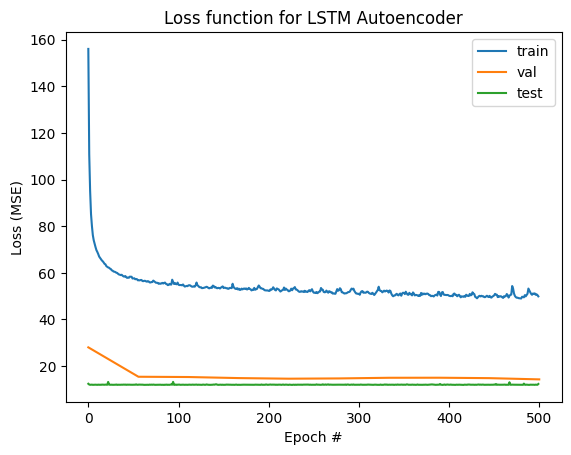

In [29]:
plt.plot(train_losses, label='train')
plt.plot(np.linspace(0, 500, 10), val_losses, label='val')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss function for LSTM Autoencoder')
plt.legend()

print(f'mean train loss: {np.mean(train_losses)}')
print(f'mean val loss: {np.mean(val_losses)}')
print(f'mean test loss: {np.mean(test_losses)}')

In [37]:
# careful, only run this if you want to overwrite the last model

#torch.save(model.encoder.state_dict(), 'models/lstm_encoder.pth')
#torch.save(model.decoder.state_dict(), 'models/lstm_decoder.pth')

In [38]:
# get the latent state representation for each timepoint, for each patient

dataset = SepsisStateDataset(df, state_cols, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

encoder = Encoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
encoder.load_state_dict(torch.load('models/lstm_encoder.pth', weights_only=True))
encoder.to(device)

decoder = Decoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
decoder.load_state_dict(torch.load('models/lstm_decoder.pth', weights_only=True))


latent_vectors = []
rec_states = []

for batch, lengths in dataloader:
    batch = batch.to(device) # batch: (batch_size, sequence_length, num_features)
    optimizer.zero_grad()

    # save latents
    latents, _ = encoder(batch, lengths, return_all_latents=True) # latents: (batch_size, sequence_length, latent_dim)
    for latent in latents: # latent: (total_num_of_timesteps_for_sequence_length_patients, latent_dim)
        latent_vectors.append(latent.detach().numpy()) # latent: (latent_dim,)

    # save reconstructed states
    x_enc, _ = encoder(batch, lengths)
    x_dec, _ = decoder(x_enc, lengths)
    for rec_state in x_dec:
        rec_states.append(rec_state.detach().numpy())
        

In [29]:
latent_vectors = np.array(latent_vectors)
print(latent_vectors.shape) # (total_num_of_timesteps, latent_dim) = (264589, 20)

latent_col_names = [f'latent_{num}' for num in range(1, 21)]
latent_df = pd.DataFrame(latent_vectors, columns=latent_col_names)
latent_df.insert(0, 'icustayid', df['icustayid'])
latent_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
latent_df.insert(2, 'terminal_state', df['terminal_state'])
latent_df.to_csv('data/latent_states.csv')
latent_df

(264589, 20)


,icustayid,died_in_hosp,terminal_state,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20
0,3,0,0,0.051479,0.105840,0.218603,-0.005050,-0.092697,-0.026727,0.383153,...,-0.122858,-0.029652,-0.270503,0.366952,-0.121099,-0.276176,0.401204,0.116674,0.449725,0.162497
1,3,0,0,0.036658,-0.014292,-0.455633,-0.130131,-0.446438,-0.115953,0.220175,...,-0.399829,0.346448,-0.118210,0.544118,0.030524,-0.188953,0.204835,0.013671,0.434835,-0.208604
2,3,0,0,-0.123223,0.122211,-0.651069,-0.132859,-0.370973,-0.185891,0.120959,...,-0.521581,0.455232,-0.155735,0.551875,0.039385,-0.055340,0.111982,0.071897,0.390884,-0.332665
3,3,0,0,-0.213202,0.161623,-0.680555,-0.083419,-0.386016,-0.237132,0.072641,...,-0.557659,0.437069,-0.172072,0.561478,0.060161,-0.086707,0.037306,0.145881,0.392386,-0.412183
4,3,0,0,-0.210289,0.115102,-0.619031,-0.070251,-0.378585,-0.275657,0.021727,...,-0.541929,0.427157,-0.172103,0.589912,0.076601,-0.131236,0.014592,0.206116,0.348763,-0.440473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.411937,0.448419,0.112609,0.369456,-0.187780,-0.022109,0.479326,...,0.019156,0.206234,-0.429560,0.234327,0.150206,0.349329,0.351227,0.023157,-0.067961,-0.078297
264585,99995,0,0,0.418585,0.470530,0.081099,0.366012,-0.196976,0.001077,0.443910,...,0.012996,0.216582,-0.429121,0.226389,0.140311,0.383798,0.340655,0.029786,-0.100113,-0.030856
264586,99995,0,0,0.421967,0.478777,0.046344,0.386336,-0.176474,0.012519,0.437661,...,-0.009908,0.223756,-0.419729,0.226116,0.134531,0.379704,0.353032,0.040258,-0.105311,-0.014117
264587,99995,0,0,0.430562,0.478043,0.025435,0.421567,-0.128286,0.013073,0.449090,...,-0.030401,0.214330,-0.422012,0.228902,0.144224,0.362823,0.389497,0.037776,-0.093504,0.000333


In [39]:
rec_states = np.array(rec_states).reshape(-1, 44)
print(rec_states.shape) # (total_num_of_timesteps, n_features) = (264589, 44)

# TODO: check column names line up!!
rec_states_df = pd.DataFrame(rec_states, columns=state_cols)
rec_states_df = rec_states_df.apply(denormalize)
rec_states_df.insert(0, 'icustayid', df['icustayid'])
rec_states_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
rec_states_df.insert(2, 'terminal_state', df['terminal_state'])
rec_states_df

#rec_states_df.to_csv('data/rec_states.csv')

(264589, 44)


,icustayid,died_in_hosp,terminal_state,gender,age,elixhauser,re_admission,Weight_kg,GCS,HR,...,Arterial_pH,paO2,paCO2,Arterial_BE,Arterial_lactate,HCO3,mechvent,Shock_Index,PaO2_FiO2,cumulated_balance
0,3,0,0,0.385430,16993.154297,3.406218,0.386618,56.314068,14.821764,97.682800,...,7.433290,127.484024,46.870476,4.756189,1.080865,17.329212,0.025730,0.725644,354.792572,112.658203
1,3,0,0,0.295489,16968.402344,3.800123,0.377796,60.701218,14.706467,97.362999,...,7.435201,107.545670,46.063469,4.819025,1.411874,16.088793,0.142981,0.732316,334.172699,4240.554688
2,3,0,0,0.248687,17327.730469,3.826240,0.361912,62.724068,14.854274,96.616898,...,7.429504,98.874741,46.321938,4.680379,1.523999,16.003674,0.116829,0.722651,318.690918,1517.027222
3,3,0,0,0.217528,17640.238281,3.760206,0.360794,63.800137,14.854300,96.767960,...,7.437562,96.493477,46.045139,4.909969,1.477349,15.900887,0.080365,0.715708,314.317352,2605.172852
4,3,0,0,0.199641,17719.179688,3.841646,0.364979,64.396591,14.845822,95.786850,...,7.437892,96.818985,46.149120,4.923867,1.482006,15.892310,0.070862,0.703218,316.511810,2411.913818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.313501,24302.312500,7.287148,0.599017,117.476311,14.874725,93.333260,...,7.369251,84.250793,25.184797,-7.886486,1.865407,20.698793,0.066513,0.671222,206.111603,948.252686
264585,99995,0,0,0.299035,24382.240234,7.213397,0.587273,117.779839,14.933954,93.581352,...,7.372363,85.952225,24.945225,-7.378788,1.813093,20.579464,0.076216,0.672960,213.286072,1681.027466
264586,99995,0,0,0.294414,24360.218750,7.196979,0.575914,117.629959,14.942873,92.998810,...,7.371879,85.751785,25.089338,-7.113889,1.790925,20.498512,0.072823,0.666817,214.721313,1356.646118
264587,99995,0,0,0.287086,24191.367188,7.156837,0.565331,117.423111,14.934848,92.659531,...,7.372844,87.185120,25.066235,-6.897107,1.777838,20.521252,0.069078,0.662186,222.122955,1438.064575


In [ ]:
# visualize latent space with t-sne

latent_tsne = TSNE(n_components=2).fit_transform(latent_vectors)

In [48]:
latent_tsne_df = pd.DataFrame(data={
    'tsne_1': latent_tsne[:, 0],
    'tsne_2': latent_tsne[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'gender': df['gender'].values,
    'age_bin': (df['age'] > df['age'].mean()).astype(int),
    'SOFA': df['SOFA'].values,
    'vasos': df['vaso_bin'].values,
    'IVs': df['iv_bin'].values
})

latent_tsne_df

,tsne_1,tsne_2,died_in_hosp,gender,age_bin,SOFA,vasos,IVs
0,-46.565533,15.233369,0,0,0,5,0,2
1,-37.423721,18.136276,0,0,0,5,0,2
2,-22.428278,36.368942,0,0,0,5,0,2
3,-15.836447,43.407368,0,0,0,5,0,2
4,-3.902473,60.291714,0,0,0,5,0,2
...,...,...,...,...,...,...,...,...
264707,18.128408,38.254070,0,0,0,0,0,0
264708,18.128408,38.254070,0,0,0,0,0,0
264709,18.128408,38.254070,0,0,0,0,0,0
264710,18.128408,38.254070,0,0,0,4,0,0


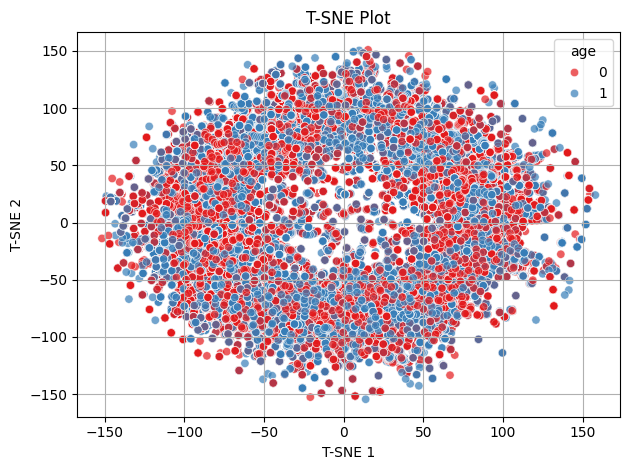

In [49]:
#plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='age_bin',
    palette='Set1',
    data=latent_tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='age')
plt.grid(True)
plt.tight_layout()
plt.show()

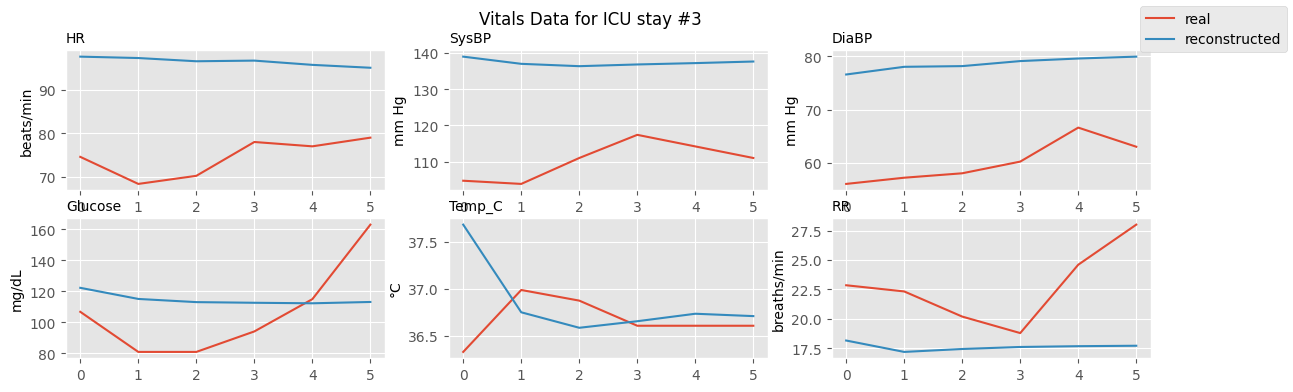

In [49]:
# visualize patient trajectories!

# plot patient trajectories

stats = ['HR', 'SysBP', 'DiaBP', 'Glucose', 'Temp_C', 'RR']
units = {'HR': 'beats/min', 'SysBP': 'mm Hg', 'DiaBP': 'mm Hg', 'Glucose': 'mg/dL', 'Temp_C': '°C', 'RR': 'breaths/min'}

def plot_trajectory(idx):
    
    patient_df = real_df[real_df['icustayid'] == idx]
    reconstructed_df = rec_states_df[rec_states_df['icustayid'] == idx]

    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, 3, figsize=(14,4))
    fig.suptitle(f'Vitals Data for ICU stay #{idx}')
    
    for ax, stat in zip(axs.flat, stats):
        ax.plot(patient_df[stat], label='real')
        ax.plot(reconstructed_df[stat], label='reconstructed')
        ax.set_title(stat, fontsize='medium', color='black', loc='left')
        ax.set_ylabel(units[stat], fontsize='medium', color='black')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()


plot_trajectory(3)
